VGG16模型與自建的模型相結合，以cifar10資料集為例

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf

from tensorflow.keras.applications import VGG16    # 多匯入這個
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np 

#載入cifar-10數據集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#正規化像素質到範圍[0,1]
x_train, x_test = x_train/255.0, x_test/255.0

# 對標籤進行編碼
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

匯入套件後，首先建立一個VGG模型

In [9]:
input_tensor = Input(shape=(32,32,3))   # 指定輸入資料的shape(cifar10資料集是32*32的彩色圖片)
vgg16 = VGG16(include_top = False, weights='imagenet',input_tensor=input_tensor)
# include_top = False : 是否使用原始模型最後的全連接層。設置為False的話，就只使用原始模型的卷積部分，做圖像特徵提取使用，然後再接到自己的模型
# weights = 'imagenet' : weights 指定imagenet，就代表利用ImageNet資料集所訓練好的權重

接著要在vgg16後面添加其他層。這邊定義一個top_model，然後將兩個模型做結合

In [32]:
top_model = vgg16.output # vgg16的輸出(output)之後緊接著top_model

# 依序建立展平層、密集層、Dropout層、密集(輸出)層
top_model = Flatten(input_shape=vgg16.output_shape[1:])(top_model)
top_model = Dense(256,activation='sigmoid')(top_model)
top_model = Dropout(0.5)(top_model)

top_model = Dense(10, activation='softmax')(top_model)   # 每一行後面都要加上這樣的敘述

model = Model(inputs=vgg16.input, outputs=top_model)  # 用上面第一行的vgg16.input(輸入)和最後一行的top_model(輸出)來建立模型

補充 : 
1.建構模型的語法和之前有點不一樣，之前都是用Sequential類別建構序列模型，此處用了另一種稱為函數式API(Functional API)的方式，它可以用來建立任何架構的神經網路(例如有分岔的神經網路)
2. 上面語法不難，主要就是每一行的最後都要以函數 (function)呼叫的方式來建立層與層的連結，因此上面可以看到最後都要加上(top_model)的敘述(一直呼叫然後串起來就對了)

將原始vgg模型前19層的權重[凍結]起來(準備直接拿來用)，以免破壞了ImageNet資料集訓練好的知識(權重)
凍結權重的語法

補充 : 
1. 使用VGG做遷移學習的目的就是想借重它萃取特徵的權重，而特徵依距離輸入資料的遠近也有高、低階之分。較靠近輸入資料的低階特徵普遍存在於大部分的圖片之中(如邊緣、線條)，所以這些低階特徵層的通用性很高，很適合凍結起來並遷移過來用(即凍結的那19層權重)。而沒有凍結那些層的權重我們還是要訓練，這些通常是萃取高階特徵的權重，這些權重都只適合它原本的訓練樣本(ImageNet 資料集)，如今面對的樣本改成了cifar10，當然必須重新訓練

In [12]:
for layer in model.layers[:19]:   # 將前19層的權重凍結不做訓練
    layer.trainable = False   

編譯與訓練模型

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# 指定訓練批次量以及訓練週期
history_transfer = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=5)

score = model.evaluate(x_test,y_test,verbose=1)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Epoch 1/5
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6439 - accuracy: 0.7748 - val_loss: 0.9035 - val_accuracy: 0.7038
Epoch 2/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6201 - accuracy: 0.7843 - val_loss: 0.9534 - val_accuracy: 0.6912
Epoch 3/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6029 - accuracy: 0.7885 - val_loss: 0.9131 - val_accuracy: 0.7037
Epoch 4/5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5807 - accuracy: 0.7961 - val_loss: 0.9307 - val_accuracy: 0.6983
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.9569 - accuracy: 0.6969
Test loss: 0.9569242000579834
Test accuracy: 0.6969000101089478


一般的CNN模型

In [20]:

import tensorflow as tf

from tensorflow.keras.applications import VGG16    # 多匯入這個
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np 

#載入cifar-10數據集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#正規化像素質到範圍[0,1]
x_train, x_test = x_train/255.0, x_test/255.0

# 對標籤進行編碼
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

建立模型

In [21]:
model = Sequential()    # 建立模型物件
model.add(Conv2D(32,(3,3), padding='same', activation='relu',input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

編譯模型

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

訓練模型

In [24]:
history_no_transfer= model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=5)
#scores = model.evaluate(x_test,y_test,verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:',scores[1])

Epoch 1/5
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7905 - accuracy: 0.7258 - val_loss: 0.9168 - val_accuracy: 0.6854
Epoch 2/5
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7533 - accuracy: 0.7402 - val_loss: 0.9209 - val_accuracy: 0.6887
Epoch 3/5
1563/1563 [==============================] - 12s 8ms/step - loss: 0.7203 - accuracy: 0.7504 - val_loss: 0.8819 - val_accuracy: 0.7018
Epoch 4/5
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6882 - accuracy: 0.7587 - val_loss: 0.9097 - val_accuracy: 0.6951
Epoch 5/5
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6650 - accuracy: 0.7706 - val_loss: 0.9129 - val_accuracy: 0.6963


畫出使用遷移學習和未使用遷移學習的圖

Text(0, 0.5, 'Accuracy')

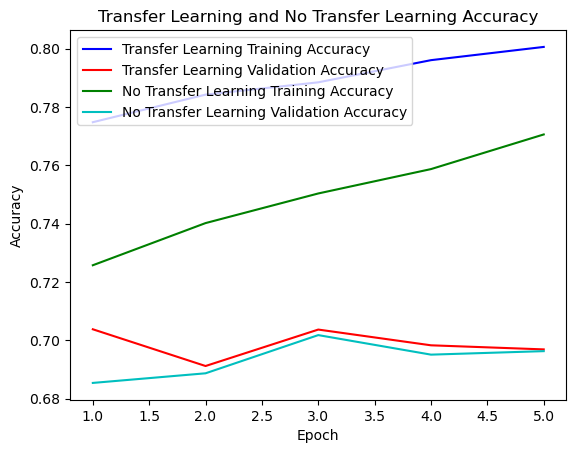

In [31]:

import matplotlib.pyplot as plt

# 假設 history_transfer 存儲了有遷移學習的模型歷史，history_no_transfer 存儲了無遷移學習的模型歷史
loss_transfer = history_transfer.history['loss']
val_loss_transfer = history_transfer.history['val_loss']
accuracy_transfer = history_transfer.history['accuracy']
val_accuracy_transfer = history_transfer.history['val_accuracy']

loss_no_transfer = history_no_transfer.history['loss']
val_loss_no_transfer = history_no_transfer.history['val_loss']
accuracy_no_transfer = history_no_transfer.history['accuracy']
val_accuracy_no_transfer = history_no_transfer.history['val_accuracy']


epochs = range(1, len(accuracy_transfer) + 1)

# 繪製有遷移學習的模型準確率曲線
plt.plot(epochs, accuracy_transfer, 'b', label='Transfer Learning Training Accuracy')
plt.plot(epochs, val_accuracy_transfer, 'r', label='Transfer Learning Validation Accuracy')

# 繪製無遷移學習的模型準確率曲線
plt.plot(epochs, accuracy_no_transfer, 'g', label='No Transfer Learning Training Accuracy')
plt.plot(epochs, val_accuracy_no_transfer, 'c', label='No Transfer Learning Validation Accuracy')
plt.title('Transfer Learning and No Transfer Learning Accuracy')
plt.legend(loc='upper left')
plt.xlabel('Epoch')   # x軸
plt.ylabel('Accuracy')  # y軸
